In [1]:
#Package loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode
from scipy.optimize import minimize

# Input validation for file path
def load_data(file_path):
    try:
        df = pd.read_excel(file_path, index_col='Date', parse_dates=True)
        # Separate NQ100 and investment assets
        nq100 = df['NQ100']
        investment_df = df.drop('NQ100', axis=1)
        return investment_df, nq100
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Dividend yields as a dictionary for better readability
DIVIDEND_YIELDS = {
    'XLY': 0.0069,
    'VZ': 0.0662,
    'UBER': 0,
    'TSLZ': 0.7567,
    'SQQQ': 0.1188,
    'SEA': 0.0936,
    'SBLK': 0.0915,
    'QYLD': 0.1124,
    'NVDA': 0.0001,
    'HYBL': 0.0819,
    'GOOG': 0.0022,
    'EVAV': 0.0349,
    'DRIV': 0.0173,
    'ARM': 0,
    'AMD': 0
}

In [2]:
def calculate_tracking_error(asset_returns, benchmark_returns):
    # Calculate return differences
    return_diff = asset_returns - benchmark_returns
    
    # Tracking Error (annualized)
    tracking_error = return_diff.std() 
    
    # Information Ratio
    active_return = asset_returns.mean() - benchmark_returns.mean()
    information_ratio = (active_return) / tracking_error if tracking_error != 0 else 0
    
    # Beta
    covariance = np.cov(asset_returns, benchmark_returns)[0][1]
    benchmark_variance = benchmark_returns.var()
    beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
    
    # R-squared
    correlation = np.corrcoef(asset_returns, benchmark_returns)[0][1]
    r_squared = correlation ** 2
    
    return {
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'beta': beta,
        'r_squared': r_squared,
        'correlation': correlation
    }    

def calculate_portfolio_metrics(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_risk
    return {
        'return': portfolio_return,
        'risk': portfolio_risk,
        'sharpe': sharpe_ratio
    }

def calculate_portfolio_tracking_error(weights, returns, benchmark_returns):
    portfolio_returns = (returns * weights).sum(axis=1)
    return_diff = portfolio_returns - benchmark_returns
    tracking_error = return_diff.std() 
    return tracking_error

In [3]:
def portfolio_objective(weights, mean_returns, cov_matrix, returns, benchmark_returns, 
                       risk_aversion=2.0, tracking_error_weight=1.0):
    # Calculate traditional portfolio metrics
    metrics = calculate_portfolio_metrics(weights, mean_returns, cov_matrix)
    portfolio_utility = metrics['return'] - (risk_aversion * metrics['risk'])
    
    # Calculate tracking error
    tracking_error = calculate_portfolio_tracking_error(weights, returns, benchmark_returns)
    
    # Combined objective: maximize utility while minimizing tracking error
    return -(portfolio_utility) + (tracking_error_weight * tracking_error)

In [4]:
def optimize_portfolio(mean_returns, cov_matrix, dividend_yields, returns, benchmark_returns,
                      min_dividend=0.05, risk_aversion=2.0, tracking_error_weight=1.0,
                      max_weight=0.30, min_weight=0.02):
    num_assets = len(mean_returns)
    
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.sum(x * dividend_yields) - min_dividend},
        {'type': 'ineq', 'fun': lambda x: max_weight - np.max(x)},
        {'type': 'ineq', 'fun': lambda x: np.min(x) - min_weight}
    ]
    
    bounds = [(min_weight, max_weight) for _ in range(num_assets)]
    sqqq_index = list(DIVIDEND_YIELDS.keys()).index('SQQQ')
    tslz_index = list(DIVIDEND_YIELDS.keys()).index('TSLZ')
    bounds[sqqq_index] = (0.01, 0.03)
    bounds[tslz_index] = (0.01, 0.03)
    
    result = minimize(portfolio_objective,
                     x0=np.array([1.0/num_assets] * num_assets),
                     args=(mean_returns, cov_matrix, returns, benchmark_returns, 
                          risk_aversion, tracking_error_weight),
                     method='SLSQP',
                     bounds=tuple(bounds),
                     constraints=constraints)
    
    if not result.success:
        print(f"Optimization failed: {result.message}")
    
    return result.x

In [5]:
def plot_portfolio_allocation(results_df, investment_amount, portfolio_dividend_yield):
    # Define a highly distinct color palette with named colors
    distinct_colors = [
        'bisque', 'cornsilk', 'sandybrown', 'tan', 'navajowhite',
        'burlywood', 'antiquewhite', 'tan', 'darkgoldenrod', 'goldenrod',
        'khaki', 'palegoldenrod', 'darkkhaki', 'gold', 'wheat'
    ]
    
    # Sort the data by weight for better visualization
    sorted_data = results_df.copy()
    sorted_data['Weight_Float'] = sorted_data['Optimal Weight'].str.rstrip('%').astype(float) / 100
    sorted_data = sorted_data.sort_values('Weight_Float', ascending=False)
    
    # Pie Chart
    plt.figure(figsize=(15, 10))
    wedges, texts, autotexts = plt.pie(sorted_data['Weight_Float'], 
                                      labels=sorted_data['Asset'],
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=distinct_colors[:len(sorted_data)],
                                      pctdistance=0.85)
    
    # Enhance pie chart readability
    plt.setp(autotexts, size=9, weight="bold")
    plt.setp(texts, size=9)
    
    # Add legend outside the pie chart with more space
    plt.legend(wedges, sorted_data['Asset'],
              title="Assets",
              loc="center left",
              bbox_to_anchor=(1.2, 0, 0.5, 1))
    
    plt.title(f'Portfolio Allocation\n(Dividend Yield: {portfolio_dividend_yield:.2%})',
              pad=20, size=12, weight='bold')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


,Tracking Error,Information Ratio,Beta,R-squared,Correlation
XLY,0.007,-0.012,0.820,0.655,0.809
QYLD,0.007,-0.149,0.478,0.655,0.809
DRIV,0.009,-0.109,0.966,0.575,0.758
HYBL,0.010,-0.114,0.088,0.162,0.403
GOOG,0.014,-0.020,0.923,0.354,0.595
SEA,0.014,-0.064,0.353,0.098,0.313
VZ,0.019,-0.019,-0.091,0.005,-0.070
SBLK,0.019,-0.059,0.434,0.066,0.258
UBER,0.021,0.040,1.019,0.221,0.470
AMD,0.025,0.018,1.856,0.459,0.677



=== Portfolio Optimization with Tracking Error Weight = 1.0 ===


,Asset,Optimal Weight,Dollar Allocation
7,XLY,22.1%,"$1,766.42"
13,HYBL,20.3%,"$1,621.91"
6,QYLD,18.5%,"$1,480.96"
5,SQQQ,13.3%,"$1,062.60"
0,NVDA,4.9%,$388.11
3,GOOG,3.0%,$240.00
4,UBER,2.0%,$160.00
12,TSLZ,2.0%,$160.00
1,ARM,2.0%,$160.00
2,AMD,2.0%,$160.00



Portfolio Dividend Yield: 7.60%


,Metric,Value
0,Portfolio Annual Return,7.79%
1,Portfolio Annual Volatility,5.22%
2,NQ100 Annual Return,35.39%
3,NQ100 Annual Volatility,17.82%


,Metric,Value
0,Tracking Error,1.00%
1,Information Ratio,-0.11
2,Beta,0.15
3,R-squared,0.25


<Figure size 640x480 with 0 Axes>

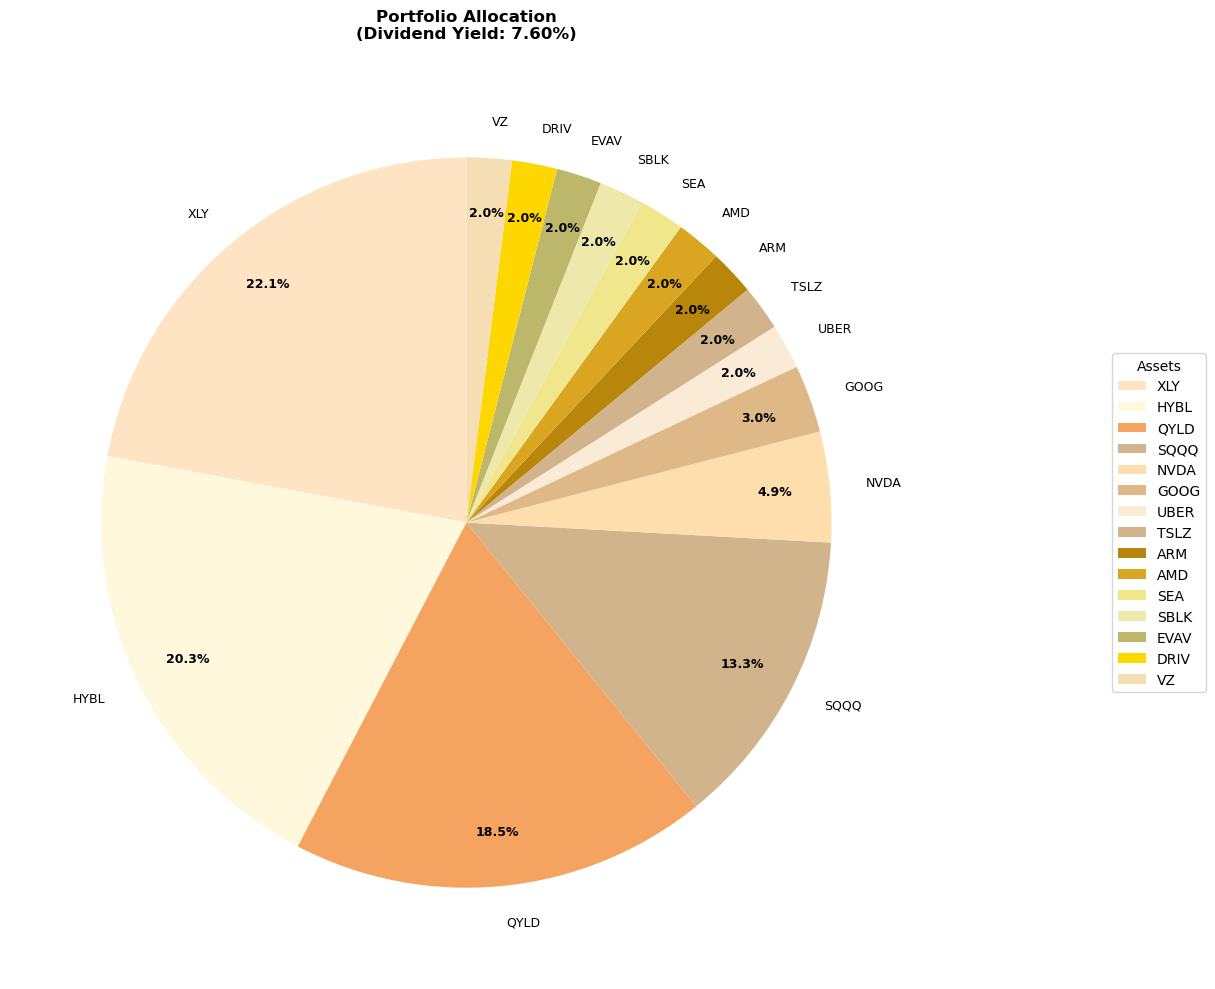

In [14]:
def main():
    # Load data
    file_path = r'D:\Derivatives Trading\US Equity Databank.xlsx'
    investment_df, nq100 = load_data(file_path)
    if investment_df is None:
        return
    
    # Calculate returns and metrics
    returns = investment_df.pct_change().dropna()
    nq100_returns = nq100.pct_change().dropna()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Calculate tracking metrics for each asset
    tracking_metrics = {}
    for column in returns.columns:
        metrics = calculate_tracking_error(returns[column], nq100_returns)
        tracking_metrics[column] = metrics
    
    # Create tracking metrics DataFrame
    tracking_metrics_df = pd.DataFrame({
        'Tracking Error': [m['tracking_error'] for m in tracking_metrics.values()],
        'Information Ratio': [m['information_ratio'] for m in tracking_metrics.values()],
        'Beta': [m['beta'] for m in tracking_metrics.values()],
        'R-squared': [m['r_squared'] for m in tracking_metrics.values()],
        'Correlation': [m['correlation'] for m in tracking_metrics.values()]
    }, index=returns.columns)
    
    # Sort by tracking error
    tracking_metrics_df = tracking_metrics_df.sort_values('Tracking Error', ascending=True)
    
    # Display tracking metrics in a separate cell
    display(pd.DataFrame(tracking_metrics_df))
    
    # Convert dividend yields dictionary to array
    dividend_yields = np.array([DIVIDEND_YIELDS[asset] for asset in returns.columns])
    
    # Try different tracking error weights
    tracking_error_weights = [1.0]
    investment_amount = 8000
    
    for te_weight in tracking_error_weights:
        print(f"\n=== Portfolio Optimization with Tracking Error Weight = {te_weight} ===")
        
        optimal_weights = optimize_portfolio(mean_returns, cov_matrix, dividend_yields,
                                          returns, nq100_returns, tracking_error_weight=te_weight)
        
        portfolio_dividend_yield = np.sum(optimal_weights * dividend_yields)
        
        # Calculate portfolio tracking error metrics
        portfolio_returns = (returns * optimal_weights).sum(axis=1)
        tracking_metrics = calculate_tracking_error(portfolio_returns, nq100_returns)
        
        # Create results DataFrame
        results_df = pd.DataFrame({
            'Asset': returns.columns,
            'Optimal Weight': optimal_weights,
            'Dollar Allocation': optimal_weights * investment_amount
        }).sort_values('Optimal Weight', ascending=False)
        
        # Format results
        results_df['Optimal Weight'] = results_df['Optimal Weight'].map('{:.1%}'.format)
        results_df['Dollar Allocation'] = results_df['Dollar Allocation'].map('${:,.2f}'.format)
        
        # Display results in a separate cell
        display(pd.DataFrame(results_df))
        
        # Print portfolio metrics
        print(f"\nPortfolio Dividend Yield: {portfolio_dividend_yield:.2%}")
        
        # Calculate and display portfolio performance metrics
        portfolio_return = portfolio_returns.mean() * 252
        portfolio_volatility = portfolio_returns.std() * np.sqrt(252)
        nq100_annual_return = nq100_returns.mean() * 252
        nq100_annual_volatility = nq100_returns.std() * np.sqrt(252)
        
        performance_metrics = pd.DataFrame({
            'Metric': ['Portfolio Annual Return', 'Portfolio Annual Volatility', 
                      'NQ100 Annual Return', 'NQ100 Annual Volatility'],
            'Value': [f"{portfolio_return:.2%}", f"{portfolio_volatility:.2%}", 
                     f"{nq100_annual_return:.2%}", f"{nq100_annual_volatility:.2%}"]
        })
        display(performance_metrics)
        
        # Display tracking error metrics
        tracking_metrics_summary = pd.DataFrame({
            'Metric': ['Tracking Error', 'Information Ratio', 'Beta', 'R-squared'],
            'Value': [f"{tracking_metrics['tracking_error']:.2%}",
                     f"{tracking_metrics['information_ratio']:.2f}",
                     f"{tracking_metrics['beta']:.2f}",
                     f"{tracking_metrics['r_squared']:.2f}"]
        })
        display(tracking_metrics_summary)
        
        # Clear the current figure to ensure clean plotting
        plt.clf()
        
        # Generate and display plot in a new cell
        plot_portfolio_allocation(results_df, investment_amount, portfolio_dividend_yield)
        plt.show()

if __name__ == "__main__":
    main()